# Práctica 3. Optimización de un modelo de ingeniería usando un algoritmo genético

A menudo, en ingeniería tenemos simulaciones de un modelo y hay que optimizar sus parámetros sin disponer de una fórmula explícita que relacione los parámetros con el comportamiento del modelo. Nos plantearemos un problema de ese tipo: tenemos una función que calcula las propiedades de una hélice en función de una serie de parámetros, pero no conocemos los cálculos que hace internamente. Disponemos de una caja negra que es un modelo de simulación (créditos: Siro Moreno y Carlos Dorado)

Aunque no es imprescindible conocer todos los detalles del modelo sí es recomendable familiarizarnos con los parámetros de configuración de la hélice que vamos a optimizar. 

In [1]:
from modelo.helice import *

In [21]:
help(calcular_helice)

Help on function calcular_helice in module modelo.helice:

calcular_helice(omega, vz, R, b, h=0, theta0=0.174, tors_param=['h', 14], chord_params=0.05)
    Calcula las propiedades de una hélice.

    Argumentos obligatorios:

        - omega: velocidad de giro de la hélice, en rad/s
        - vz: velocidad de avance, en m/s
        - R : radio de la hélice
        - b : número de palas

    Argumentos opcionales:

        - h : altitud de vuelo, en metros sobre el nivel del mar
        - theta0 : ángulo de paso colectivo
        - tors_param : parámetros de torsión de la hélice:
            formato: [ley, p]
                p: Parámetro: número o lista
                Ley:describe la forma de la ley de torsiones, y puede ser:
                    - 'c': distribución de torsión constante = p
                    - 'l': distribución de torsión lineal, con p[0] en la raíz y p[1] en la punta
                    - 'h': distribución de torsión hiperbólica, con torsión p en la punta
        - c

Lo primero que tendrás que hacer es definir una representación adecuada para los cromosomas que representan un diseño de la hélice en base a sus parámetros. Nuestra hélice depende de varios parámetros que queremos optimizar. Podemos decidir optimizar algunos mateniendo un valor controlado de otros. 

***Como sugerencia*** se proponen los siguientes parámetros de optimización: 

- omega (velocidad de rotación) (Entre 0 y 200 radianes/segundo)
- R (radio de la hélice) (Entre 0.1 y 2 metros)
- b (número de palas) (Entre 2 y 5 palas) 
- theta0 (ángulo de paso colectivo) (Entre -0.26 y 0.26 radianes)(*se corresponde a -15 y 15 grados*)
- p (parámetro de torsión) (Entre -5 y 20 grados)
- cuerda (anchura de la pala) (Entre 0.01 y 0.2 metros)

y fijar los parámetros:
- vz (velocidad de vuelo)
- h (altura de vuelo)

Ten en cuenta que necesitarás funciones de decodificación hay que transformar la representación binaria en variables con sentido físico. Por ejemplo, si el entero de la variable Omega está entre 0 y 1023 (10bits), pero la variable Omega real estará entre 0 y 200 radianes por segundo, el valor se calcula como:
    omega = genes[0] * 200 / 1023
    
del mismo modo, para R:
    R =  0.1 + genes[1] * 1.9 / 1023 #Obtendremos un radio entre 0.1 y 2 metros
    
El número de palas debe ser un entero:
    b = genes[2] + 2 #(entre 2 y 5 palas)
    
    
Para la función de fitness usaremos la función que calcula el desempeño del rotor según sus parámetros:

    T, P, efic, mach_punta = calcular_rotor(omega, vz, R, b, h...) #Introduce las variables que uses de parámetro.
                                                                # Consulta la ayuda para asegurarte de que usas el 
                                                                # formato correcto!
Recuerda que T es la tracción de la hélice, P es la Potencia consumida por la hélice, efic representa la eficiencia propulsiva de la hélice y mach_punta representa el mach en la punta de las palas. El número de mach en las puntas de la hélice se refiere a la velocidad relativa de las puntas de la hélice con respecto a la velocidad del sonido en el aire circundante.

Antes de seguir vamos a observar en las gráficas cómo cambian las características de la hélice (tracción, potencia, eficiencia y mach de las puntas) para cada valor de velocidad de vuelto (avance en m/s). Fijamos unos ciertos parámetros para ver el desempeño de la hélice.    

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [9]:
vel = np.linspace(0, 30, 100)
# La función linspace() devuelve 100 valores espaciados uniformemente dentro del intervalo especificado [0, ] 
# zeros_like return an array of zeros with the same shape and type as a given array.
efic = np.zeros_like(vel)
T = np.zeros_like(vel)
P = np.zeros_like(vel)
mach = np.zeros_like(vel)
for i in range(len(vel)):
    T[i], P[i], efic[i], mach[i] = calcular_helice(130, vel[i], 0.5, 3)

Text(0.5, 1.0, 'Eficiencia de la hélice')

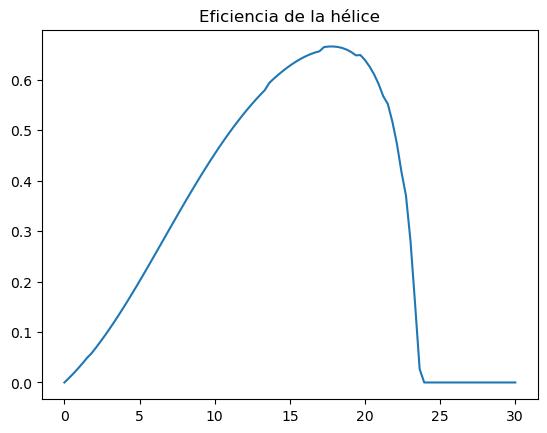

In [11]:
plt.plot(vel, efic)
plt.title('Eficiencia de la hélice')

Text(0.5, 1.0, 'Tracción de la hélice')

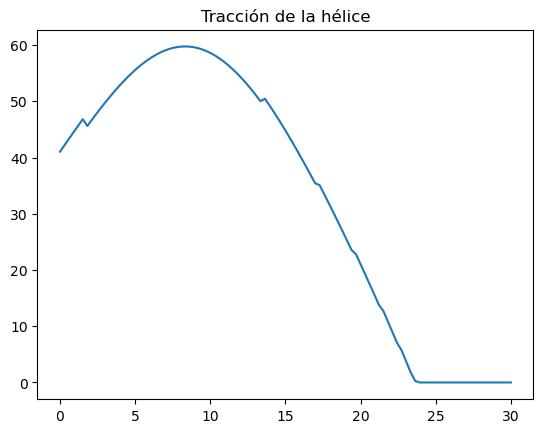

In [13]:
plt.plot(vel, T)
plt.title('Tracción de la hélice')

Text(0.5, 1.0, 'Potencia consumida')

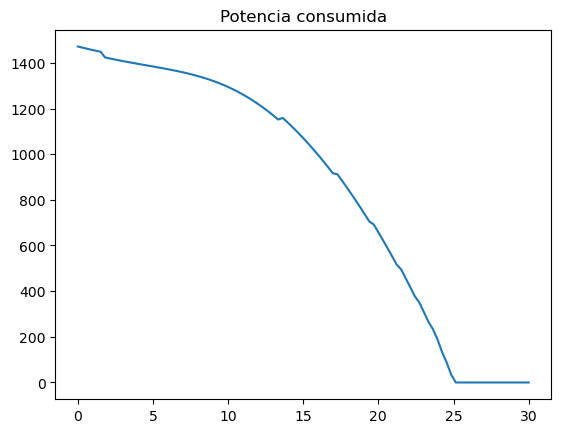

In [15]:
plt.plot(vel, P)
plt.title('Potencia consumida')

Text(0.5, 1.0, 'Mach en la punta de las palas')

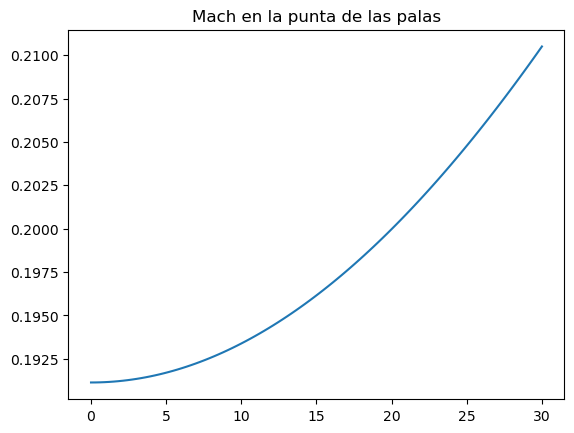

In [17]:
plt.plot(vel, mach)
plt.title('Mach en la punta de las palas')

Si quieres puedes observar también el impacto del resto de parámetros. 

Para la ejecución del algoritmo tendrás que definir una **función de fitness** adecuada según lo que decidas optimizar.

Por ejemplo, si buscáramos que tuviera la tracción máxima sin preocuparnos de nada más, el valor de fitnes sería simplemente igual al de T:

    fitness = T

Si queremos imponer restricciones, por ejemplo, que la potencia sea menor a 1000 watios, se pueden añadir sentencias del tipo:

    if P > 1000:
        fitness -= 1000
        
Si queremos optimizar varias salidas podemos hacerlo de manera ponderada:

    fitness = parámetro_importante * 10 + parámetro_poco_importante * 0.5
    
También se pueden combinar diferentes funciones no lineales:

    fitness = parámetro_1 * parámetro_2 - parámetro_3 **2 * log(parámetro_4)

Puedes elegir con qué objetivo quieres optimizar la hélice pero te hacemos algunas sugerencias de posibles objetivos de optimización:

    - Maximizar la tracción (manteniendo una tracción mínima de 30 Newtons) con el mínimo radio posible.
    - Mínima potencia consumida posible, máxima eficiencia propulsiva, y mínimo radio posible (sin ser este criterio muy importante), manteniendo una tracción mínima de 40 Newtons y un mach en la punta de las palas de como mucho 0.7
    - Máximizar la eficiencia cuando vuela a 70 m/s, y maximizar la tracción por encima de 50 Newtons para el despegue (vz = 0)    

### Se pide utilizar un algoritmo genético para encontrar la mejor configuración de parámetros para el modelo de hélice dado y comentar los resultados obtenidos. 

Documentar convenientemente el código y justificar las decisiones para la configuración del algoritmo genético. 

In [134]:
class ProblemaGenetico(object):
        def __init__(self, genes,fun_dec,fun_muta , fun_cruza, fun_fitness,longitud_individuos):
            self.genes = genes
            self.fun_dec = fun_dec
            self.fun_cruza = fun_cruza
            self.fun_muta = fun_muta
            self.fun_fitness = fun_fitness
            self.longitud_individuos = longitud_individuos
            """Constructor de la clase"""
                
        def decodifica(self, genotipo):
            """Devuelve el fenotipo a partir del genotipo"""
            fenotipo = self.fun_dec(genotipo)
            return fenotipo
        def muta(self, cromosoma,prob):
            """Devuelve el cromosoma mutado"""   
            mutante = self.fun_muta(cromosoma,prob)
            return mutante
        def cruza(self, cromosoma1, cromosoma2):         
            """Devuelve el cruce de un par de cromosomas"""
            cruce = self.fun_cruza(cromosoma1,cromosoma2)
            return cruce 
        def fitness(self, cromosoma):    
            """Función de valoración"""
            valoracion = self.fun_fitness(cromosoma)
            return valoracion

In [136]:
#Definir la función nueva_generacion
def nueva_generacion(problema_genetico, k,opt, poblacion, n_padres, n_directos, prob_mutar):
    padres2 = seleccion_por_torneo(problema_genetico, poblacion, n_directos, k,opt) 
    padres1 = seleccion_por_torneo(problema_genetico, poblacion, n_padres , k, opt)
    cruces =  cruza_padres(problema_genetico,padres1)
    generacion = padres2+cruces
    resultado_mutaciones = muta_individuos(problema_genetico, generacion, prob_mutar)
    return resultado_mutaciones

In [138]:
def algoritmo_genetico(problema_genetico,k,opt,ngen,size,prop_cruces,prob_mutar):
    poblacion= poblacion_inicial(problema_genetico,size)
    n_padres=round(size*prop_cruces)
    n_padres= int (n_padres if n_padres%2==0 else n_padres-1)
    n_directos = size-n_padres
    for _ in range(ngen):
        poblacion= nueva_generacion(problema_genetico,k,opt,poblacion,n_padres, n_directos,prob_mutar)

    mejor_cr= opt(poblacion, key=problema_genetico.fitness)
    mejor=problema_genetico.decodifica(mejor_cr)
    return (mejor,problema_genetico.fitness(mejor_cr)) 

In [140]:
# Será necesaria la siguiente función que interpreta una lista de 0's y 1's como un número natural:  
def binario_a_decimal(x):
    x=x[::-1]
    #result = sum(b * (2**i) for (i, b) in enumerate(x))
    result = np.sum(np.fromiter((b * (2**i) for (i, b) in enumerate(x)), dtype=float))
    return result

In [142]:
def poblacion_inicial(problema_genetico, size):
    """
    Genera una población inicial de individuos representados como listas de bits, 
    cada uno siguiendo una estructura específica de sublistas.
    
    :param problema_genetico: Un objeto que contiene información sobre los genes y la longitud deseada.
    :param size: El tamaño de la población (número de individuos).
    :return: Una lista de individuos, donde cada individuo es una lista de listas de bits.
    """
    # Definir la estructura específica de cada individuo: [[10 bits], [10 bits], [2 bits], [10 bits], [10 bits], [10 bits]]
    estructura = [10, 10, 2, 10, 10, 10]
    
    poblacion = []  # Lista para almacenar la población
    
    for _ in range(size):
        individuo = []  # Cada individuo será una lista de listas
        for longitud in estructura:
            # Generar una sublista de bits de la longitud especificada en 'estructura'
            sublista = [random.choice(problema_genetico.genes) for _ in range(longitud)]
            individuo.append(sublista)
        poblacion.append(individuo)  # Añadir el individuo generado a la población
    
    return poblacion

In [144]:
def cruza_padres(problema_genetico,padres):
    l = []
    for i in range(len(padres)//2):# asumimos que la población de la que partimos tiene tamaño par
        desc = problema_genetico.fun_cruza(padres[2*i],padres[2*i+1]) # El cruce se realiza con la función de cruce  
                                                                     # proporcionada por el propio problema genético
        l.append(desc[0]) # La población resultante se obtiene de cruzar el padre[0] con padre[1], padre[2] con padre[3]...
        l.append(desc[1]) # y añadir cada par de descendientes a la nueva población
    return l

In [146]:
def muta_individuos(problema_genetico, poblacion, prob):
    mutados = []
    for x in poblacion:
        mutados.append(problema_genetico.fun_muta(x,prob))
    return mutados

In [148]:
def seleccion_por_torneo(problema_genetico, poblacion, n, k, opt):
    """Selección por torneo de n individuos de una población. Siendo k el nº de participantes
        y opt la función max o min."""
    seleccionados = []
    for i in range(n):
        participantes = random.sample(poblacion,k)
        seleccionado = opt(participantes, key=problema_genetico.fitness)
        opt(poblacion, key=problema_genetico.fitness)
        seleccionados.append(seleccionado)
        # poblacion.remove(seleccionado)
    return seleccionados 

In [170]:
def funcion_decodificador(genotipo):
    print(genotipo)
    print(len(genotipo))
    p_values = ['c','l','h']
    numeros = [binario_a_decimal(elemento) for elemento in genotipo]
    numeros[0] = numeros[0]*200/1023
    numeros[1] = 0.1 + numeros[1] * 1.9/1023
    numeros[2] = numeros[2] + 2
    numeros[3] = -0.26 + numeros[3] * 0.52/1023
    ley =  numeros[4]/(2**8)
    p = -5 + (numeros[4]%(2**8))*25/255
    numeros[4] =[p_values[int(ley)],p]
    numeros[5] = 0.01 + numeros[5]*0.19/1023
    print(numeros)
    return numeros
     

In [172]:
def fun_cruzar(cromosoma1, cromosoma2):
    """Cruza los cromosomas por la mitad (podemos cambiar la función de cruce eligiendo otro punto de cruce al azar)"""
    l1 = len(cromosoma1)
    l2 = len(cromosoma2)
    cruce1 = cromosoma1[0:l1//2]+cromosoma2[l1//2:l2]
    cruce2 = cromosoma2[0:l2//2]+cromosoma1[l2//2:l1]
    return [cruce1,cruce2]

def fun_mutar(cromosoma,prob):
    """Elige un elemento al azar del cromosoma y lo modifica con una probabilidad igual a prob"""
    l = len(cromosoma)
    p = random.randint(0,l-1)
    if prob > random.uniform(0,1):
        cromosoma[p] =  (cromosoma[p]+1)%2
    return cromosoma

In [174]:
def fun_fitness(cromosoma):
    omega, R, b, theta0, p, cuerda = funcion_decodificador(cromosoma)

    #fijar estos dos
    vz = 50
    h = 100
    
    T, P, efic, mach_punta = calcular_helice(omega, vz, R, b, h, theta0, p, cuerda)

    #función(es) de fitness real
    n = (T - 30) * 10 - R * 5 #Maximizar la tracción (manteniendo una tracción mínima de 30 Newtons) con el mínimo radio posible.
    '''n = - P * 10 + efic * 10 - R * 4 + (T - 40) * 10 - (mach_punta - 0.7 * 10 #Mínima potencia consumida posible, máxima eficiencia propulsiva, y mínimo radio posible (sin ser este criterio muy importante), manteniendo una tracción mínima de 40 Newtons y un mach en la punta de las palas de como mucho 0.7
    
    vz = 70
    T70, P70, efic70, mach_punta70 = calcular_helice(omega, vz, R, b, h, theta0, p, cuerda)
    vz = 0
    T0, P0, efic0, mach_punta0 = calcular_helice(omega, vz, R, b, h, theta0, p, cuerda)
    n = efic70 + (T0 - 50) #Máximizar la eficiencia cuando vuela a 70 m/s, y maximizar la tracción por encima de 50 Newtons para el despegue (vz = 0)'''
    return n

In [176]:
funcion1 = ProblemaGenetico([0,1],funcion_decodificador,fun_mutar, fun_cruzar, fun_fitness,52)

In [178]:
algoritmo_genetico(funcion1,3,min,20,10,0.7,0.1)

[[1, 0, 0, 1, 0, 0, 1, 1, 0, 0], [1, 0, 1, 0, 1, 0, 0, 1, 0, 1], [1, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 1], [0, 1, 1, 1, 0, 1, 1, 0, 0, 1], [0, 1, 0, 1, 0, 0, 0, 0, 1, 1]]
6
[114.95601173020528, 1.3573802541544477, 4.0, 0.256950146627566, ['l', 16.274509803921568], 0.06999022482893451]
Law not recogniced:  <class 'numpy.float64'>
ERROR ERROR ERROR ERROR ERROR 


TypeError: can't multiply sequence by non-int of type 'numpy.float64'